# Quantum control via commutative pop optimization

In [15]:
import matplotlib.pyplot as plt

import numpy as np

import pickle

from qutip import propagator, Qobj

from qcontrol_polyopt import CQCPolyOptDyson, CQCPolyOptMagnus

from sympy import I, diag, Float, symbols, lambdify, sympify

from sympy.matrices import randMatrix, matrix2numpy, 

ImportError: cannot import name 'numpy2matrix' from 'sympy.matrices' (/Users/dbondar/opt/anaconda3/lib/python3.8/site-packages/sympy/matrices/__init__.py)

# Constructing a quantum system

In [10]:
# Quantum system is taken from https://github.com/q-optimize/c3/blob/master/examples/two_qubits.ipynb

# Drift Hamiltonian 
H0 = np.array([[0.00000000e+00+0.j, 0.00000000e+00+0.j, 0.00000000e+00+0.j],
       [0.00000000e+00+0.j, 3.21505101e+10+0.j, 0.00000000e+00+0.j],
       [0.00000000e+00+0.j, 0.00000000e+00+0.j, 6.23173079e+10+0.j]])

# Control Hamiltonian
V = np.array([[0.        +0.j, 1.        +0.j, 0.        +0.j],
       [1.        +0.j, 0.        +0.j, 1.41421356+0.j],
       [0.        +0.j, 1.41421356+0.j, 0.        +0.j]])

array([0.00000000e+00+0.j, 3.21505101e+10+0.j, 6.23173079e+10+0.j])

In [14]:
# Convert to simpy matrices 

# keep the field free Hamiltonian diagonal (it is better for sympy evaluation)
H0 = diag(*([Float(_) for _ in np.diag(H0)]))
V = get_random_matrix(4)    

NameError: name 'get_random_matrix' is not defined

Generate random quantum system with the hamiltonian
$\hat{H}(t) = \hat{H}_0 + u(t) \hat{V}$,
where $u(t)$ is a control field.

In [4]:
qsys_params = dict(
    
    H0 = H0,
    V = V0,
    
    # final time
    T = 1, 
    
    # polynomial order for the control
    npoly=6,
    
    min_module='both',
    #min_module='scipy',
    #min_module='ncpol2sdpa',
)

# convert sympy matrix to qutip objects for subsequent propagation 
H0 = Qobj(matrix2numpy(qsys_params['H0']))
V = Qobj(matrix2numpy(qsys_params['V']))

# Perform calculations

In [29]:
amplitudes = [2, 10, 100]#[0.1, 0.5, 2, 10,]

fidelity_dyson_scipy = []
fidelity_dyson_ncpol2sdpa = []

fidelity_magnus_scipy = []
fidelity_magnus_ncpol2sdpa = []


for ampl in amplitudes:
    # the chosen control
    u_original_str = '{} * sin(2 * 3.1416 * 10 * t)'.format(ampl)

    # get target unitary
    U_target = propagator([H0, [V, u_original_str]], qsys_params['T'])

    # covert the chosen control to the numpy function for plotting
    #t = symbols('t')
    #u_original = lambdify(t, sympify(u_original_str), 'numpy')
    
    dyson_result = CQCPolyOptDyson(U_target=U_target, **qsys_params)
    
    U_dyson = propagator([H0, [V, dyson_result.u_reconstructed['scipy'][0]]], dyson_result.T)
    fidelity_dyson_scipy.append(
        (U_dyson - U_target).norm()
    )
    print(fidelity_dyson_scipy[-1])
    
    U_dyson = propagator([H0, [V, dyson_result.u_reconstructed['ncpol2sdpa'][0]]], dyson_result.T)
    fidelity_dyson_ncpol2sdpa.append(
        (U_dyson - U_target).norm()
    )
    print(fidelity_dyson_ncpol2sdpa[-1])
    
    
    magnus_result = CQCPolyOptMagnus(U_target=U_target, **qsys_params)
    U_magnus = propagator([H0, [V, magnus_result.u_reconstructed['scipy'][0]]], magnus_result.T)
    fidelity_magnus_scipy.append(
        (U_magnus - U_target).norm()
    )
    print(fidelity_magnus_scipy[-1])
    
    U_magnus = propagator([H0, [V, magnus_result.u_reconstructed['ncpol2sdpa'][0]]], magnus_result.T)
    fidelity_magnus_ncpol2sdpa.append(
        (U_magnus - U_target).norm()
    )
    print(fidelity_magnus_ncpol2sdpa[-1])
    
    print(ampl)
    print("============================================================")
    

0.022015643292602263
0.02201564332216131
1.7702202692162932
1.7702219636787337
2
0.10912571368499199
0.10912571376891557
1.770448521569426
1.7704114329675775
10
0.4394684241779014
0.4394684243584061
1.8358666246290296
1.8358605872371023
100


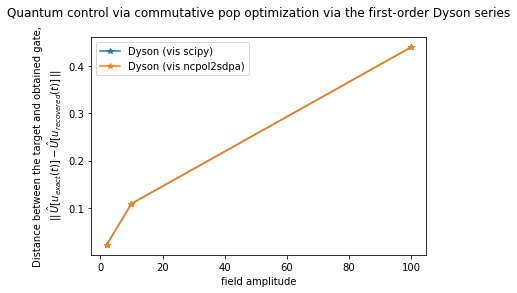

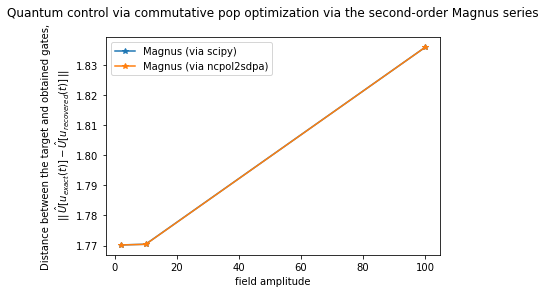

In [30]:
plt.title("Quantum control via commutative pop optimization via the first-order Dyson series\n")

plt.plot(amplitudes, fidelity_dyson_scipy, '*-', label='Dyson (vis scipy)')
plt.plot(amplitudes, fidelity_dyson_ncpol2sdpa, '*-', label='Dyson (vis ncpol2sdpa)')
plt.xlabel('field amplitude')
plt.ylabel('Distance between the target and obtained gate,\n $||\, \hat{U}[u_{exact}(t)] - \hat{U}[u_{recovered}(t)] \,||$')
plt.legend()
plt.show()

plt.title("Quantum control via commutative pop optimization via the second-order Magnus series\n")
plt.plot(amplitudes, fidelity_magnus_scipy, '*-', label='Magnus (via scipy)')
plt.plot(amplitudes, fidelity_magnus_ncpol2sdpa, '*-', label='Magnus (via ncpol2sdpa)')

plt.xlabel('field amplitude')
plt.ylabel('Distance between the target and obtained gates,\n $||\, \hat{U}[u_{exact}(t)] - \hat{U}[u_{recovered}(t)] \,||$')
plt.legend()
plt.show()